# _Waste Classification for_  <font color='skblue'>***SAID***</font>  _Architecture_

Waste disposal is often a concern for various reasons including *eutrophication, toxic waste consumption by animals and land, air or water pollution.* 

Old architectures of dustbins either requires usage of multiple bins, which allows us to choose the correct dustbin for organic and recycleable waste, but most of the times, its the human error or ignorance that introduces the need for further waste segregation techniques, utilizing more time and captial. This ML algorithm helps SAID dustbin architecture to segregate waste based on image data acquired using lenses equipped within the SAID bin. The waste will be segregated into either of the two categories - 

- <font color='lightgreen'> _**Organic Waste**_ </font> 
- <font color='skyblue'> _**Recyclable Waste**_ </font>   

<!-- `Note - ` -->
<br><font color='lightgreen'> **Organic Waste** </font>  _can broadly be classified as <font color='lightgreen'>**Wet Waste**</font>_ & <font color='skyblue'> **Recyclable Waste** </font>   _can be broadly classified as <font color='skyblue'>**Dry Waste**</font>_ which makes it easier to comprehend what exactly we are trying to segregate.<br><br>




### **About the Dataset**

A custom dataset was used which incorporated a portion of some of the widely available datasets, which includes

  - [TechSash](https://www.kaggle.com/techsash/waste-classification-data) 
  - [TrashNet](https://github.com/garythung/trashnet)
  - [TACO](http://tacodataset.org/)
<br><br>

### Importing libraries and checking if CUDA is available for GPU acceleration of the code.

In [145]:
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Interactive graph plotting
import matplotlib.colors as colors  # Color-related operations

%matplotlib inline  
# Configure figure format for high-resolution displays
%config InlineBackend.figure_format = 'retina'  

import torch  # Deep learning framework used to accelerate model training process
from torch import nn  # Neural network module for building ANN based models
from torch import optim  # Optimization module for parameter optimization
import torch.nn.functional as F  # Functional module for various functions
from torchvision import datasets, models  # Datasets, transforms, and pre-trained models for computer vision tasks
import torchvision.transforms as transforms  # Transformations for preprocessing images in computer vision tasks
from torch.utils.data.sampler import SubsetRandomSampler  # Sampler for randomly sampling elements from a dataset


**`Note -`** We will be using <font color="salmon">**PyTorch**</font>, since it provides 
- **Dynamic computational graphs** - allows efficient backpropagation and gradient computation.
- **GPU acceleration** - allows efficient ans super-accelerated model training and inference on GPUs, 
- Provides access to numerous **Pre-Trained deep-neural models, libraries, and resources.**
<br><br>

#### Let us check if we can access CUDA using pytorch

In [146]:
# checking if CUDA is available for utilizing accelerated computing through use of a Graphics Card
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Data Augmentation

Data Augmentation is basically cropping, resizing, flipping the image data to get more accurate results. <br><br>This can be done in PyTorch using **transforms** . Also, Normalization helps get data within a range and reduces the skewness which helps learn faster and better. Normalization is done in PyTorch by **transforms.Normalize** wherein two tuples are passed, one tuple has mean for all the three RGB channels followed by the second tuple having standard deviation for all three channels.<br><br> Data Augmentation is mostly done in training data as it is important to have more accuracy in training so that eventually test accuracy is better. This also increases the amount of training images. Hence, multiple augmentations can be applied on train samples.

In [147]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

### Loading the Directories of Training and Testing data.

In [148]:
# Loading Training and Testing dataset 
train_data = datasets.ImageFolder('./data/train', transform=train_transforms)
test_data = datasets.ImageFolder('./data/test', transform=test_transforms)

##### Splitting the Training Dataset into <font color='lightgreen'>*Train samples*</font> and <font color='lightgreen'>*Validation samples*</font> to cross check Accuracies. This is done using `SubsetRandomSampler` function of <font color="salmon">PyTorch</font>

In [149]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

print(f"Train Loader Size: {len(train_loader)}")

Train Loader Size: 592


In [150]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 

# defining classes
classes=['O','R']

Plotting the images to understand the data.<br>
<font color="green">**O -> Organic Waste**</font> <br>
<font color="skyblue">**R ->  Recyclable Waste**</font>

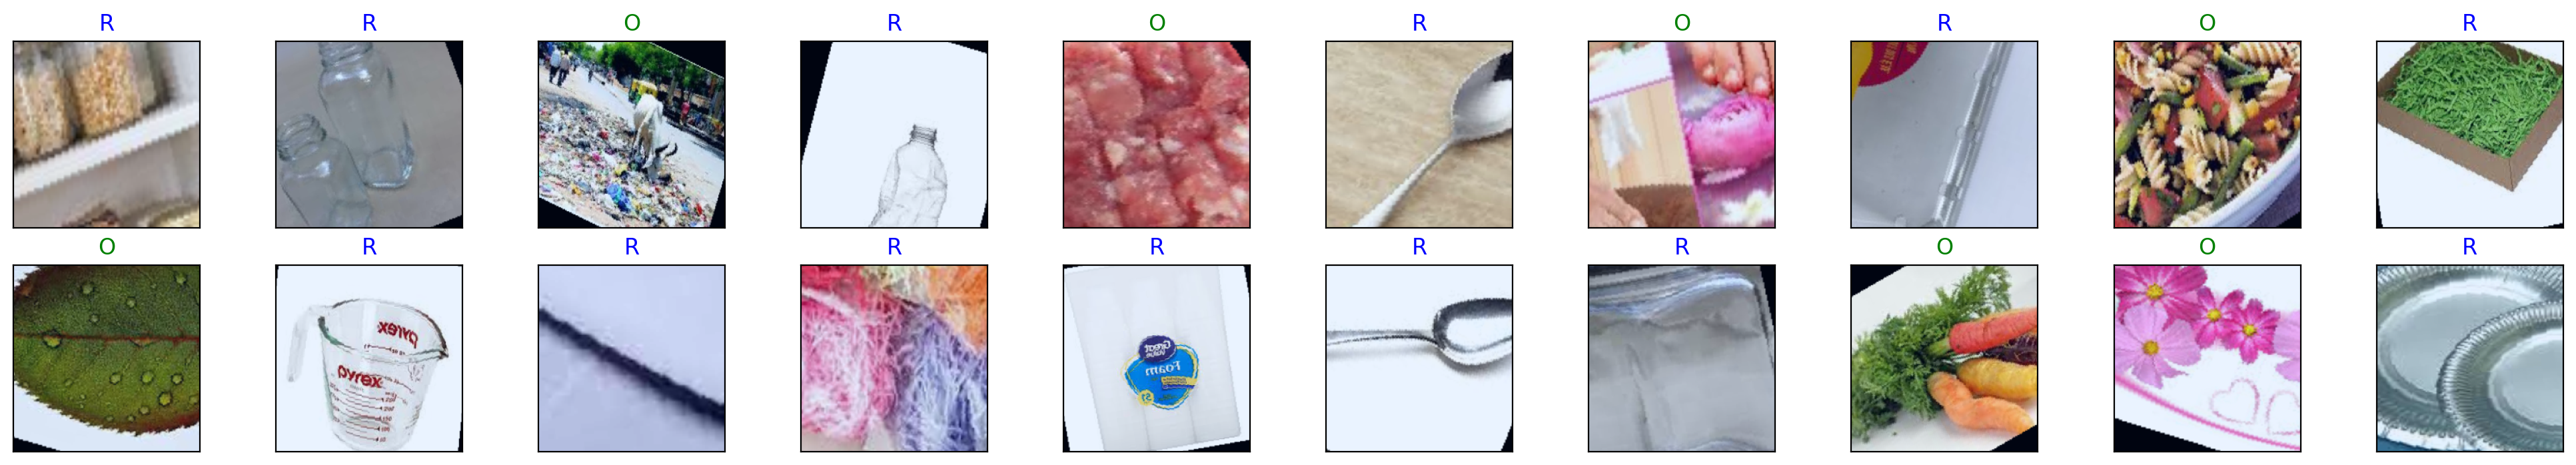

In [151]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    
    img = images[idx].numpy()  # convert image tensor to numpy array
    img = np.transpose(img, (1, 2, 0)) 
    img_min, img_max = img.min(), img.max()
    img = (img - img_min) / (img_max - img_min)
    
    ax.imshow(img)  # rearrange dimensions to (height, width, channels)
    ax.set_title(classes[labels[idx]], color='blue' if classes[labels[idx]]=='R' else 'green')

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])
tensor(0)


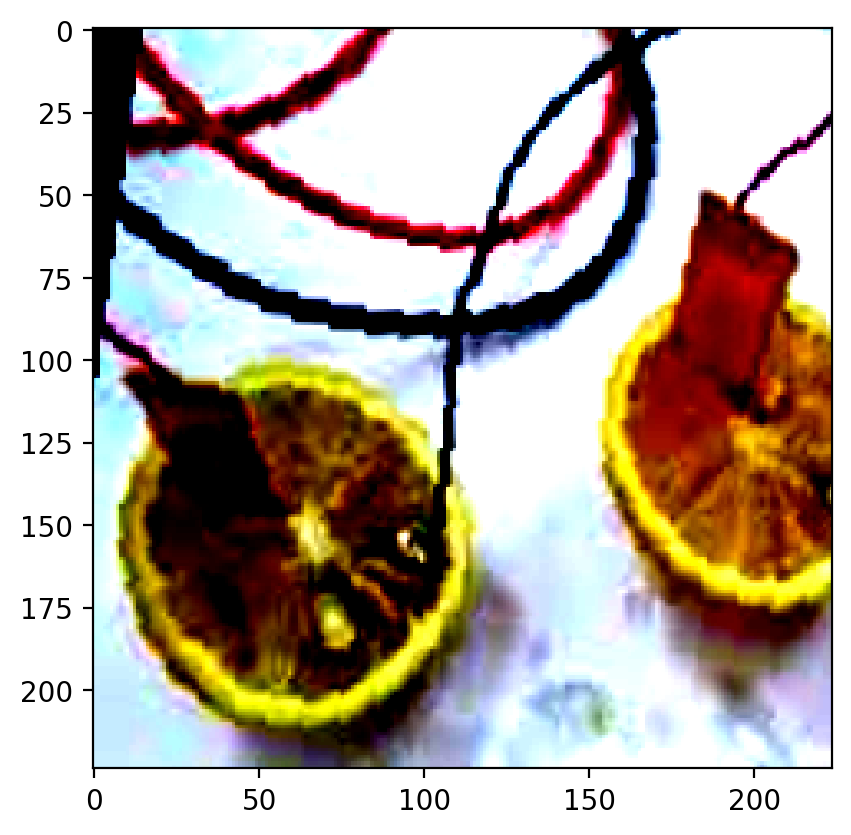

In [163]:
batch = next(iter(train_loader))
print(batch[0].shape)
plt.imshow(batch[0][0].permute(1, 2, 0))
print(batch[1][0])

# Transfer Learning

Transfer Learning refers to the process of using already existing pre-trained models for other applications by tweaking the last few layers and using it to classify our desired classes.
Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our organic and recyclable waste photos with near perfect accuracy.

With `torchvision.models` these pre-trained networks can be downloaded and used in applications.

Here, the `DenseNet121` is used. DenseNet is a very powerful model with 121 layers.
For more information about densenet, [visit documentation](https://www.kaggle.com/pytorch/densenet121).

## Densenet architecture
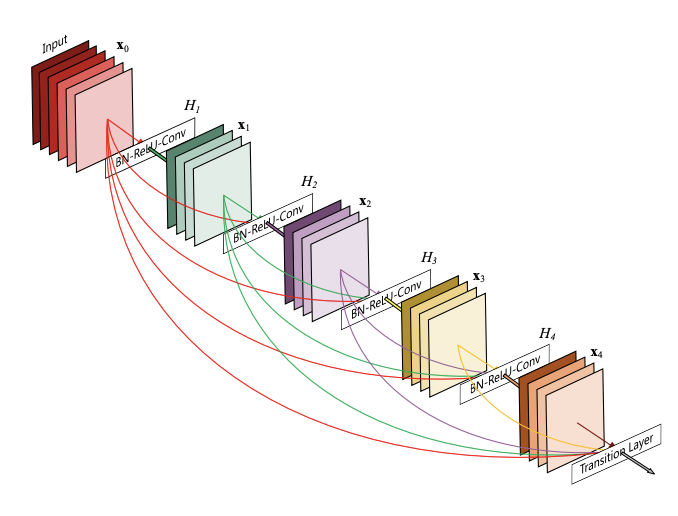

Dense Convolutional Network (DenseNet), connects each layer to every other layer in a feed-forward fashion. <br>

In [174]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [176]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

# Training the Model

Training the model for desired number of epochs and keeping track of train loss and validation loss. If the validation loss decreases, the model is saved.The simplest thing to do is simply save the state dict with `torch.save`.

In [125]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(0, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training the model
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    # validating the model
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss} \tValidation Loss: {valid_loss}')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min} --> {valid_loss}).  Saving model ...')
        torch.save(model.state_dict(), 'trained_model_02.pt')
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 0.198909218850431 	Validation Loss: 0.16656734929786127
Validation loss decreased (inf --> 0.16656734929786127).  Saving model ...
Epoch: 1 	Training Loss: 0.19116662306156446 	Validation Loss: 0.1688309915596816
Epoch: 2 	Training Loss: 0.1990245299163985 	Validation Loss: 0.15530303935579395
Validation loss decreased (0.16656734929786127 --> 0.15530303935579395).  Saving model ...
Epoch: 3 	Training Loss: 0.1953386585779874 	Validation Loss: 0.17079453739642292
Epoch: 4 	Training Loss: 0.19352665780561107 	Validation Loss: 0.1598157197589705
Epoch: 5 	Training Loss: 0.19424391203413774 	Validation Loss: 0.15599579723679405
Epoch: 6 	Training Loss: 0.20065894667524573 	Validation Loss: 0.16284875661159912
Epoch: 7 	Training Loss: 0.19848157212080716 	Validation Loss: 0.16902549172470555
Epoch: 8 	Training Loss: 0.19282254932564272 	Validation Loss: 0.16610325462265935
Epoch: 9 	Training Loss: 0.1928663542841991 	Validation Loss: 0.18095333271188346
Epoch: 10 	

Loading the last saved model for testing.

In [177]:
model.load_state_dict(torch.load('trained_model_02.pt'))

<All keys matched successfully>

### Testing the model

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(2):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy (Overall): {100. * np.sum(class_correct) / np.sum(class_total)} ({int(np.sum(class_correct))}/{int(np.sum(class_total))})')

Test Loss: 0.212124


Test Accuracy (Overall): 94.02985074626865 (126/134)


`As observed here, the model has an Average accuracy of 94.02% `

# Testing the Results

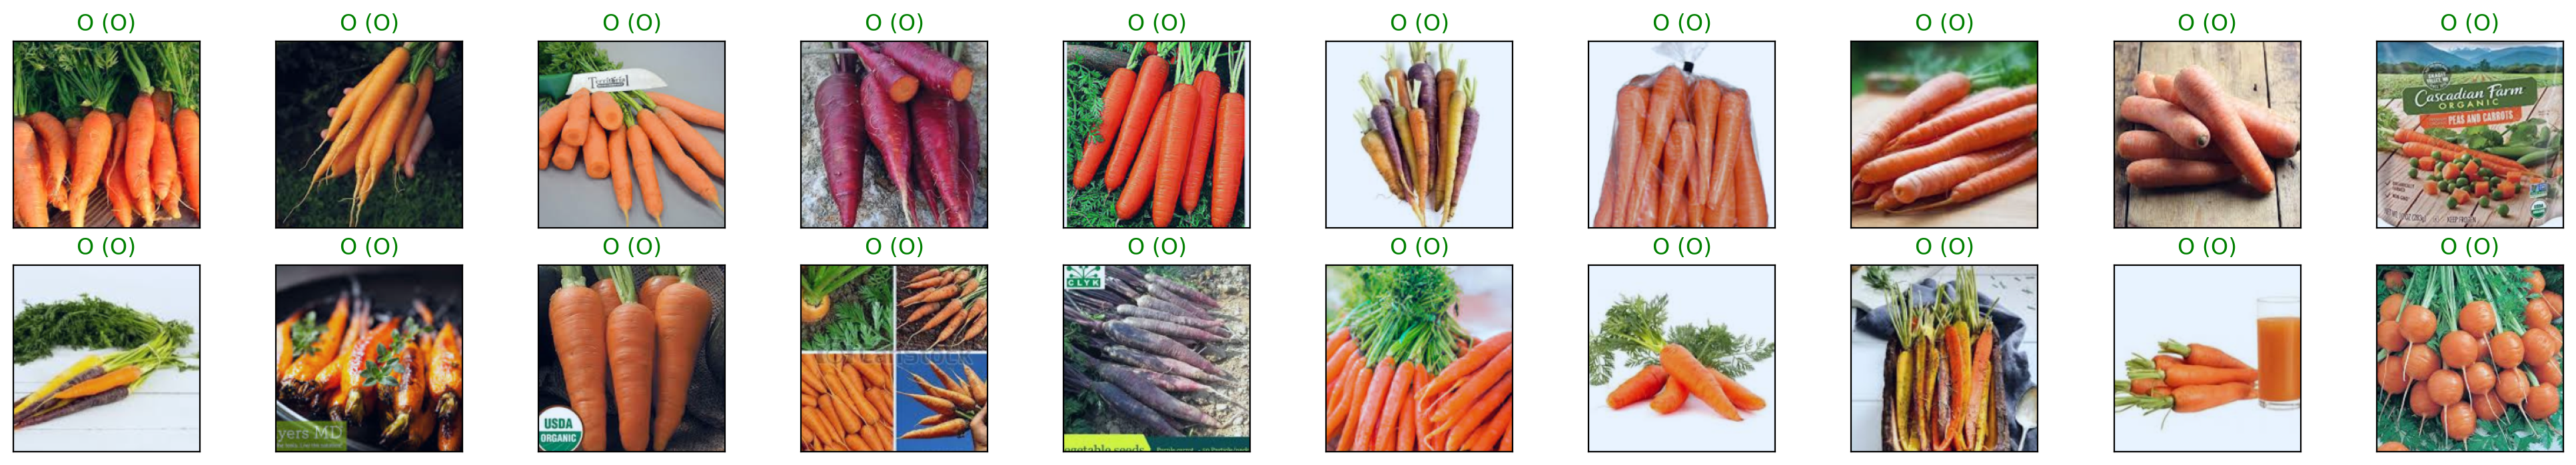

In [87]:
# obtaining a single batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.__next__()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plotting the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    img = images.cpu()[idx]
    img = img.permute(1, 2, 0)  # change dimension order for imshow
    # Scale pixel values between 0 and 1
    img_min, img_max = img.min(), img.max()
    img = (img - img_min) / (img_max - img_min)
    
    ax.imshow(img)
    ax.set_title(f"{classes[preds[idx]]} ({classes[labels[idx]]})", color=("green" if preds[idx]==labels[idx].item() else "red"))
plt.show()